In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import h5py 

In [2]:
f1 = h5py.File('train_128.h5', 'r')
list(f1.keys())
X1 = f1['data']
X_full= np.array(X1.value)

In [3]:
f1 = h5py.File('train_label.h5', 'r')
list(f1.keys())
Y1 = f1['label']
Y_full= np.array(Y1.value)

In [94]:
def oneHotIt(Y):
    m = Y.shape[0]
    #Y = Y[:,0]
    OHX = scipy.sparse.csr_matrix((np.ones(m), (Y, np.array(range(m)))))
    OHX = np.array(OHX.todense()).T 
    return OHX

def normalize(X):
    mu_train = np.mean(X,axis=0,keepdims=True)
    var_train = np.var(X,axis=0,keepdims=True)
    X_norm = (X-mu_train) / np.sqrt(var_train)
    
    return X_norm, mu_train, var_train

def normalize_test(X_norm, mu_train, var_train):
    X_norm = (X_norm-mu_train) / np.sqrt(var_train)
    
    return X_norm

In [139]:
train_X = X_full[0:50000]
train_X, mu_train, var_train = normalize(train_X)
train_X = train_X.T

train_Y = Y_full[0:50000]
train_Y = oneHotIt(train_Y).T

dev_X = X_full[50000:]
dev_X = normalize_test(dev_X,mu_train,var_train)
dev_X = dev_X.T

dev_Y = Y_full[50000:]
dev_Y = oneHotIt(dev_Y).T

print(train_X.shape)
print(train_Y.shape)
print(dev_X.shape)
print(dev_Y.shape)

(128, 50000)
(10, 50000)
(128, 10000)
(10, 10000)


In [22]:
def compute_cost(a3, Y):
    """
    Computes the cost
    
    Arguments:
    a3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    logits = a3.T
    labels = Y.T
    
    cost = -np.sum((np.log(np.sum(labels*logits,axis=1, keepdims=True))))/logits.shape[0]

    return cost

In [140]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def relu(x):
    """
    Compute the relu of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- relu(x)
    """
    s = np.maximum(0,x)
    
    return s

def initialize_parameters(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    b1 -- bias vector of shape (layer_dims[l], 1)
                    Wl -- weight matrix of shape (layer_dims[l-1], layer_dims[l])
                    bl -- bias vector of shape (1, layer_dims[l])
                    
    Tips:
    - For example: the layer_dims for the "Planar Data classification model" would have been [2,2,1]. 
    This means W1's shape was (2,2), b1 was (1,2), W2 was (2,1) and b2 was (1,1). Now you have to generalize it!
    - In the for loop, use parameters['W' + str(l)] to access Wl, where l is the iterative integer.
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*  np.sqrt(2 / layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters

def forward_propagation(X, parameters):
    """
    Implements the forward propagation (and computes the loss) presented in Figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape ()
                    b1 -- bias vector of shape ()
                    W2 -- weight matrix of shape ()
                    b2 -- bias vector of shape ()
                    W3 -- weight matrix of shape ()
                    b3 -- bias vector of shape ()
    
    Returns:
    loss -- the loss function (vanilla logistic loss)
    """
    
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> Batch-Norm -> RELU -> LINEAR -> Batch-Norm -> RELU -> LINEAR -> Batch-Norm -> SOFTMAX
    z1 = np.dot(W1, X) + b1
    a1 = relu(z1)
    z2 = np.dot(W2, a1) + b2
    a2 = relu(z2)
    z3 = np.dot(W3, a2) + b3
    a3 = softmax(z3.T).T
    
    cache = (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3)
    
    return a3, cache

def backward_propagation(X, Y, cache):
    """
    Implement the backward propagation presented in figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat)
    cache -- cache output from forward_propagation()
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    m = X.shape[1]
    (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3) = cache
    
    dz3 = a3 - Y
    dW3 = np.dot(dz3, a2.T)
    db3 = np.sum(dz3, axis=1, keepdims = True)
    
    da2 = np.dot(W3.T, dz3)
    dz2 = np.multiply(da2, np.int64(a2 > 0))
    dW2 = np.dot(dz2, a1.T)
    db2 = np.sum(dz2, axis=1, keepdims = True)
    
    da1 = np.dot(W2.T, dz2)
    dz1 = np.multiply(da1, np.int64(a1 > 0))
    dW1 = np.dot(dz1, X.T)
    db1 = np.sum(dz1, axis=1, keepdims = True)
    
    gradients = {"dz3": dz3, "dW3": dW3, "db3": db3,
                 "da2": da2, "dz2": dz2, "dW2": dW2, "db2": db2,
                 "da1": da1, "dz1": dz1, "dW1": dW1, "db1": db1}
    
    return gradients

def predict(X, y, parameters):
    """
    This function is used to predict the results of a  n-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    p = np.zeros((10,m), dtype = np.int)
    accuracy = 0 
    
    # Forward propagation
    a3, caches = forward_propagation(X, parameters)
    
    # convert probas to 0/1 predictions
    for j in range(0,10):
        for i in range(0, a3.shape[1]):
            if a3[j,i] == np.max(a3[:,i]):
                p[j,i] = 1
            else:
                p[j,i] = 0
    
    for i in range(0,a3.shape[1]):
        accuracy += (p[:,i] == y[:,i]).all()
    accuracy = accuracy / a3.shape[1]
    print("Accuracy: "  + str(accuracy))
    
    return 


In [41]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    """
    Implements the backward propagation of our baseline model to which we added an L2 regularization.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation()
    lambd -- regularization hyperparameter, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T) + W3*lambd/m
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T) + W2*lambd/m
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T) + W1*lambd/m
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [42]:
def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    """
    Implements the forward propagation: LINEAR -> RELU + DROPOUT -> LINEAR -> RELU + DROPOUT -> LINEAR -> SIGMOID.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape (20, 2)
                    b1 -- bias vector of shape (20, 1)
                    W2 -- weight matrix of shape (3, 20)
                    b2 -- bias vector of shape (3, 1)
                    W3 -- weight matrix of shape (1, 3)
                    b3 -- bias vector of shape (1, 1)
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    A3 -- last activation value, output of the forward propagation, of shape (1,1)
    cache -- tuple, information stored for computing the backward propagation
    """
    
    np.random.seed(1)
    
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> Batch-Norm -> RELU -> LINEAR -> Batch-Norm -> RELU -> LINEAR -> Batch-Norm -> SOFTMAX
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    D1 = np.random.rand(A1.shape[0],A1.shape[1])      # Step 1: initialize matrix D1 = np.random.rand(..., ...)
    D1 = (D1 < keep_prob)                             # Step 2: convert entries of D1 to 0 or 1 (using keep_prob as the threshold)
    A1 = A1*D1                                        # Step 3: shut down some neurons of A1
    A1 = A1/keep_prob                                 # Step 4: scale the value of neurons that haven't been shut down

    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)

    D2 = np.random.rand(A2.shape[0],A2.shape[1])       # Step 1: initialize matrix D2 = np.random.rand(..., ...)
    D2 = (D2 < keep_prob)                              # Step 2: convert entries of D2 to 0 or 1 (using keep_prob as the threshold)
    A2 = A2*D2                                         # Step 3: shut down some neurons of A2
    A2 = A2/keep_prob                                  # Step 4: scale the value of neurons that haven't been shut down

    Z3 = np.dot(W3, A2) + b3
    A3 = softmax(Z3.T).T
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

In [43]:
def backward_propagation_with_dropout_L2(X, Y, cache, keep_prob, lambd):
    """
    Implements the backward propagation of our baseline model to which we added dropout.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation_with_dropout()
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T) + W3*lambd/m
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    dA2 = np.dot(W3.T, dZ3)

    dA2 = dA2*D2                                    # Step 1: Apply mask D2 to shut down the same neurons as during the forward propagation
    dA2 = dA2/keep_prob                             # Step 2: Scale the value of neurons that haven't been shut down
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T) + W2*lambd/m
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)

    dA1 = dA1*D1                                   # Step 1: Apply mask D1 to shut down the same neurons as during the forward propagation
    dA1 = dA1/keep_prob                            # Step 2: Scale the value of neurons that haven't been shut down
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T) + W1*lambd/m
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [44]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    """
    Implements the backward propagation of our baseline model to which we added dropout.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation_with_dropout()
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    dA2 = np.dot(W3.T, dZ3)

    dA2 = dA2*D2                                     # Step 1: Apply mask D2 to shut down the same neurons as during the forward propagation
    dA2 = dA2/keep_prob                              # Step 2: Scale the value of neurons that haven't been shut down
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dA1 = dA1*D1                                     # Step 1: Apply mask D1 to shut down the same neurons as during the forward propagation
    dA1 = dA1/keep_prob                              # Step 2: Scale the value of neurons that haven't been shut down
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [45]:
def calculate_batch_mean_var(x, eps):

  N, D = x.shape

  #step1: calculate mean
  mu = 1./N * np.sum(x, axis = 0)

  #step2: subtract mean vector of every trainings example
  xmu = x - mu

  #step3: following the lower branch - calculation denominator
  sq = xmu ** 2

  #step4: calculate variance
  var = 1./N * np.sum(sq, axis = 0)

  #step5: add eps for numerical stability, then sqrt
  sqrtvar = np.sqrt(var + eps)

  #step6: invert sqrtwar
  ivar = 1./sqrtvar

  return mu,ivar,sqrtvar,var,eps

In [46]:
def update_parameters_with_gd(parameters, grads, learning_rate):
    """
    Update parameters using one step of gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters to be updated:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients to update each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    learning_rate -- the learning rate, scalar.
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(parameters) // 2 # number of layers in the neural networks

    # Update rule for each parameter
    for l in range(L):
        parameters["W" + str(l+1)] = parameters['W' + str(l+1)] - learning_rate*grads['dW' + str(l+1)]
        parameters["b" + str(l+1)] = parameters['b' + str(l+1)] - learning_rate*grads['db' + str(l+1)]

        
    return parameters

In [47]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [48]:
def initialize_velocity(parameters):
    """
    Initializes the velocity as a python dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    
    Returns:
    v -- python dictionary containing the current velocity.
                    v['dW' + str(l)] = velocity of dWl
                    v['db' + str(l)] = velocity of dbl
    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    
    # Initialize velocity
    for l in range(L):
        
        v["dW" + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
   
    return v

In [49]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    """
    Update parameters using Momentum
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- python dictionary containing the current velocity:
                    v['dW' + str(l)] = ...
                    v['db' + str(l)] = ...
    beta -- the momentum hyperparameter, scalar
    learning_rate -- the learning rate, scalar
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- python dictionary containing your updated velocities
    """

    L = len(parameters) // 2 # number of layers in the neural networks
    
    # Momentum update for each parameter
    for l in range(L):
    
        # compute velocities
        v["dW" + str(l+1)] = beta*v["dW" + str(l+1)]+(1-beta)*grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta*v["db" + str(l+1)]+(1-beta)*grads['db' + str(l+1)]
        # update parameters
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-learning_rate*v["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-learning_rate*v["db" + str(l+1)]
     
    return parameters, v

In [50]:
def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):

        v["dW" + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
    
    return v, s

In [51]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".

        v["dW" + str(l+1)] = beta1*v["dW" + str(l+1)]+(1-beta1)*grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta1*v["db" + str(l+1)]+(1-beta1)*grads["db" + str(l+1)]

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".

        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)]/(1-beta1**(t))
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)]/(1-beta1**(t))

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l+1)] = beta2*s["dW" + str(l+1)]+(1-beta2)*(grads["dW" + str(l+1)]**2)
        s["db" + str(l+1)] = beta2*s["db" + str(l+1)]+(1-beta2)*(grads["db" + str(l+1)]**2)

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)]/(1-beta2**(t))
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)]/(1-beta2**(t))

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-learning_rate*v_corrected["dW" + str(l+1)]/((s_corrected["dW" + str(l+1)])**(1/2)+epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-learning_rate*v_corrected["db" + str(l+1)]/((s_corrected["db" + str(l+1)])**(1/2)+epsilon)

    return parameters, v, s

In [122]:
def model(X, Y, layers_dims, optimizer, regularizer = "No",keep_prob = 0.85, lambd = 0.7, learning_rate_init = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 10000, print_cost = True):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        learning_rate = learning_rate_init * (1/(1+0.01*i))
        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            if regularizer == "DropOut":
                a3, caches = forward_propagation_with_dropout(minibatch_X, parameters,keep_prob)
            elif regularizer == "DropOut_L2":
                a3, caches = forward_propagation_with_dropout(minibatch_X, parameters,keep_prob)
            else:
                a3, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost
            cost = compute_cost(a3, minibatch_Y)

            # Backward propagation
            if regularizer == "No":
                grads = backward_propagation(minibatch_X, minibatch_Y, caches)
            elif regularizer == "L2":
                grads = backward_propagation_with_regularization(minibatch_X, minibatch_Y, caches,lambd)
            elif regularizer == "DropOut":
                grads = backward_propagation_with_dropout(minibatch_X, minibatch_Y, caches, keep_prob)
            elif regularizer == "DropOut_L2":
                grads = backward_propagation_with_dropout_L2(minibatch_X, minibatch_Y, caches, keep_prob, lambd)
                
            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        
        # Print the cost every 1000 epoch
        if print_cost and i % 10 == 0:
            print ("Cost after epoch %i: %f" %(i, cost))
        if print_cost and i % 10 == 0:
            costs.append(cost)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 10)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

0.3
0.3
Cost after epoch 0: 3.685930
Cost after epoch 10: 2.239031
Cost after epoch 20: 1.789332
Cost after epoch 30: 1.635794
Cost after epoch 40: 1.555993
Cost after epoch 50: 1.503918
Cost after epoch 60: 1.461812
Cost after epoch 70: 1.463659
Cost after epoch 80: 1.431900
Cost after epoch 90: 1.464923
Cost after epoch 100: 1.464356
Cost after epoch 110: 1.391880
Cost after epoch 120: 1.442308
Cost after epoch 130: 1.420722
Cost after epoch 140: 1.553947
Cost after epoch 150: 1.431679
Cost after epoch 160: 1.429698
Cost after epoch 170: 1.434296
Cost after epoch 180: 1.442650
Cost after epoch 190: 1.384786


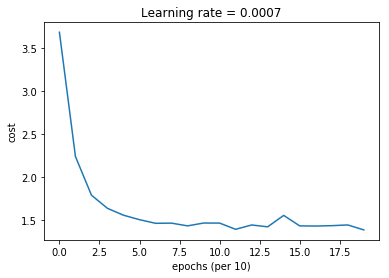

[2.45931736e-03 5.69441190e-08 3.53943499e-01 1.57552805e-03
 3.87059580e-01 2.04131061e-06 2.40706250e-01 1.07143423e-09
 1.42469781e-02 6.74817124e-06]
[0 0 0 0 1 0 0 0 0 0]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Accuracy: 0.75666
[0.21504157 0.01972644 0.16995961 0.12983279 0.15414776 0.02347422
 0.19700749 0.00619407 0.07957886 0.00503719]
[1 0 0 0 0 0 0 0 0 0]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy: 0.7519
0.3
0.5
Cost after epoch 0: 3.685198
Cost after epoch 10: 2.237586
Cost after epoch 20: 1.775312
Cost after epoch 30: 1.631284
Cost after epoch 40: 1.548066
Cost after epoch 50: 1.500297
Cost after epoch 60: 1.469012
Cost after epoch 70: 1.454514
Cost after epoch 80: 1.439250
Cost after epoch 90: 1.491207
Cost after epoch 100: 1.464502
Cost after epoch 110: 1.413552
Cost after epoch 120: 1.452522
Cost after epoch 130: 1.434509
Cost after epoch 140: 1.546396
Cost after epoch 150: 1.466736
Cost after epoch 160: 1.442870
Cost after epoch 170: 1.430052
Cost after epoch 180: 1.451383
Cost

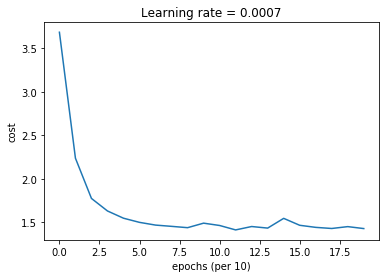

[4.96880071e-03 2.40897180e-05 3.54667123e-01 6.57403186e-03
 3.87348683e-01 5.22970946e-05 2.44610429e-01 1.33795799e-05
 3.84427097e-04 1.35673923e-03]
[0 0 0 0 1 0 0 0 0 0]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Accuracy: 0.7591
[0.19773568 0.03301818 0.17721028 0.12179084 0.15929077 0.01958961
 0.20455654 0.00716398 0.07378475 0.00585936]
[0 0 0 0 0 0 1 0 0 0]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy: 0.7528
0.3
0.7
Cost after epoch 0: 3.684409
Cost after epoch 10: 2.234626
Cost after epoch 20: 1.761790
Cost after epoch 30: 1.623829
Cost after epoch 40: 1.540582
Cost after epoch 50: 1.493561
Cost after epoch 60: 1.469206
Cost after epoch 70: 1.461559
Cost after epoch 80: 1.444695
Cost after epoch 90: 1.474244
Cost after epoch 100: 1.468305
Cost after epoch 110: 1.411456
Cost after epoch 120: 1.470888
Cost after epoch 130: 1.458079
Cost after epoch 140: 1.537594
Cost after epoch 150: 1.466190
Cost after epoch 160: 1.442994
Cost after epoch 170: 1.432118
Cost after epoch 180: 1.498240
Cost 

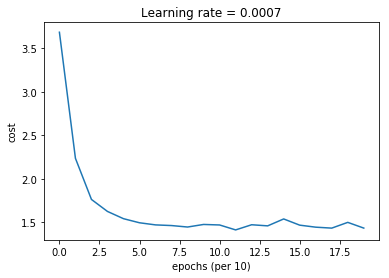

[5.40817636e-03 5.08778445e-05 3.54991928e-01 4.21612023e-03
 3.84358756e-01 3.86540624e-04 2.47395588e-01 6.20410721e-05
 1.31345826e-03 1.81651348e-03]
[0 0 0 0 1 0 0 0 0 0]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Accuracy: 0.74628
[0.19744641 0.04620951 0.16761204 0.13194321 0.15425992 0.01730055
 0.19005122 0.01071915 0.07456834 0.00988965]
[1 0 0 0 0 0 0 0 0 0]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy: 0.7396
0.3
1
Cost after epoch 0: 3.683500
Cost after epoch 10: 2.229700
Cost after epoch 20: 1.748300
Cost after epoch 30: 1.609764
Cost after epoch 40: 1.540805
Cost after epoch 50: 1.484996
Cost after epoch 60: 1.479067
Cost after epoch 70: 1.457881
Cost after epoch 80: 1.457631
Cost after epoch 90: 1.464707
Cost after epoch 100: 1.494041
Cost after epoch 110: 1.429086
Cost after epoch 120: 1.473762
Cost after epoch 130: 1.458160
Cost after epoch 140: 1.541898
Cost after epoch 150: 1.453255
Cost after epoch 160: 1.469537
Cost after epoch 170: 1.448232
Cost after epoch 180: 1.497111
Cost a

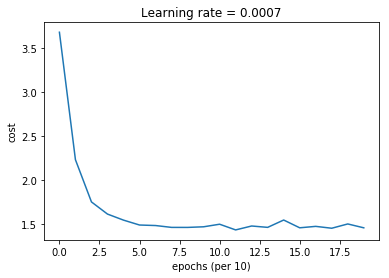

[2.09129514e-03 7.76004246e-05 3.56928870e-01 8.30859137e-04
 3.88676009e-01 5.02379922e-03 2.41042111e-01 1.08040813e-03
 2.91180288e-03 1.33724540e-03]
[0 0 0 0 1 0 0 0 0 0]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Accuracy: 0.74276
[0.20462687 0.07648113 0.14201723 0.15796513 0.13146665 0.01915383
 0.16598987 0.01529923 0.07552653 0.01147354]
[1 0 0 0 0 0 0 0 0 0]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy: 0.7326
0.5
0.3
Cost after epoch 0: 2.679794
Cost after epoch 10: 1.549129
Cost after epoch 20: 1.136628
Cost after epoch 30: 1.107088
Cost after epoch 40: 1.063013
Cost after epoch 50: 0.962347
Cost after epoch 60: 1.019603
Cost after epoch 70: 0.916717
Cost after epoch 80: 1.020354
Cost after epoch 90: 0.980508
Cost after epoch 100: 0.940800
Cost after epoch 110: 0.945512
Cost after epoch 120: 0.942683
Cost after epoch 130: 0.989845
Cost after epoch 140: 1.068419
Cost after epoch 150: 0.881364
Cost after epoch 160: 1.013670
Cost after epoch 170: 0.935221
Cost after epoch 180: 0.950128
Cost

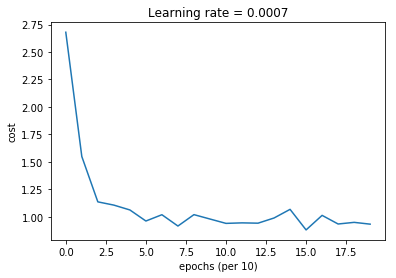

[6.92302595e-03 1.70297303e-13 2.00717201e-01 1.24602143e-04
 5.55392979e-01 1.88001822e-03 2.04252429e-01 2.99078888e-13
 3.07097452e-02 4.43936052e-13]
[0 0 0 0 1 0 0 0 0 0]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Accuracy: 0.85024
[3.35491212e-01 2.12814582e-08 5.47488218e-02 5.92591816e-02
 8.29647129e-02 4.56344516e-04 4.61918396e-01 8.84727248e-10
 5.16129433e-03 1.54352166e-08]
[0 0 0 0 0 0 1 0 0 0]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy: 0.8358
0.5
0.5
Cost after epoch 0: 2.679097
Cost after epoch 10: 1.537560
Cost after epoch 20: 1.132053
Cost after epoch 30: 1.100634
Cost after epoch 40: 1.070579
Cost after epoch 50: 0.965526
Cost after epoch 60: 1.021164
Cost after epoch 70: 0.925875
Cost after epoch 80: 1.030957
Cost after epoch 90: 0.989899
Cost after epoch 100: 0.950513
Cost after epoch 110: 0.950188
Cost after epoch 120: 0.944578
Cost after epoch 130: 0.986792
Cost after epoch 140: 1.086145
Cost after epoch 150: 0.888058
Cost after epoch 160: 1.012472
Cost after epoch 170: 0.9

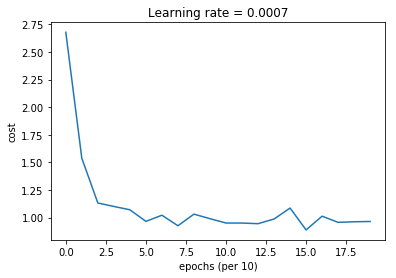

[6.94610211e-03 4.67519252e-07 2.29045243e-01 7.58773182e-04
 5.27697462e-01 2.38492897e-03 2.03865779e-01 3.91503680e-08
 2.91759816e-02 1.25223678e-04]
[0 0 0 0 1 0 0 0 0 0]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Accuracy: 0.84796
[3.89974801e-01 2.37859361e-06 4.53902437e-02 8.30535025e-02
 4.71495662e-02 3.24982330e-04 4.27092148e-01 5.48928571e-08
 7.01127709e-03 1.04622661e-06]
[0 0 0 0 0 0 1 0 0 0]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy: 0.8383
0.5
0.7
Cost after epoch 0: 2.678575
Cost after epoch 10: 1.524921
Cost after epoch 20: 1.131616
Cost after epoch 30: 1.099764
Cost after epoch 40: 1.075661
Cost after epoch 50: 0.972415
Cost after epoch 60: 1.028835
Cost after epoch 70: 0.921799
Cost after epoch 80: 1.026556
Cost after epoch 90: 0.976190
Cost after epoch 100: 0.951662
Cost after epoch 110: 0.956232
Cost after epoch 120: 0.947650
Cost after epoch 130: 1.008170
Cost after epoch 140: 1.089151
Cost after epoch 150: 0.897769
Cost after epoch 160: 1.015131
Cost after epoch 170: 0.9

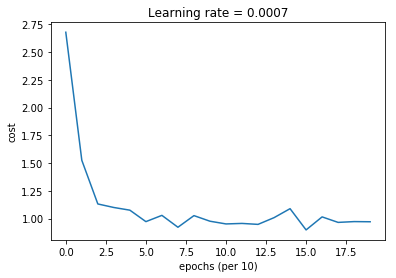

[1.02665521e-02 1.21764151e-05 2.24680246e-01 1.37673982e-03
 5.23370294e-01 3.75097062e-03 2.10177630e-01 1.96487691e-06
 2.59219154e-02 4.41511037e-04]
[0 0 0 0 1 0 0 0 0 0]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Accuracy: 0.84722
[4.01088411e-01 1.33822178e-05 4.11966799e-02 8.43536306e-02
 3.72711091e-02 1.09180047e-03 4.26050895e-01 8.94203746e-07
 8.92761194e-03 5.58476156e-06]
[0 0 0 0 0 0 1 0 0 0]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy: 0.8352
0.5
1
Cost after epoch 0: 2.677638
Cost after epoch 10: 1.508922
Cost after epoch 20: 1.126506
Cost after epoch 30: 1.096972
Cost after epoch 40: 1.077921
Cost after epoch 50: 0.971049
Cost after epoch 60: 1.027765
Cost after epoch 70: 0.921399
Cost after epoch 80: 1.042129
Cost after epoch 90: 1.002657
Cost after epoch 100: 0.979254
Cost after epoch 110: 0.965285
Cost after epoch 120: 0.971878
Cost after epoch 130: 1.017419
Cost after epoch 140: 1.107617
Cost after epoch 150: 0.921531
Cost after epoch 160: 1.013614
Cost after epoch 170: 1.003

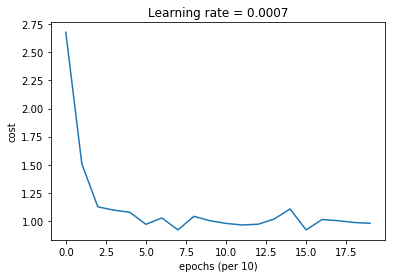

[1.07972102e-03 3.86814323e-05 2.10994424e-01 1.75185469e-03
 5.45120340e-01 8.25622909e-03 2.23032006e-01 1.51707109e-05
 1.46087247e-03 8.25070078e-03]
[0 0 0 0 1 0 0 0 0 0]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Accuracy: 0.84424
[2.31740257e-01 1.59343418e-04 6.58627302e-02 6.54391733e-02
 7.83207565e-02 3.95136132e-03 5.37064122e-01 2.47407154e-05
 1.72140922e-02 2.23423488e-04]
[0 0 0 0 0 0 1 0 0 0]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy: 0.8349
0.7
0.3
Cost after epoch 0: 2.421417
Cost after epoch 10: 1.025907
Cost after epoch 20: 0.789640
Cost after epoch 30: 0.711711
Cost after epoch 40: 0.687469
Cost after epoch 50: 0.641343
Cost after epoch 60: 0.634280
Cost after epoch 70: 0.598880
Cost after epoch 80: 0.683694
Cost after epoch 90: 0.634879
Cost after epoch 100: 0.587485
Cost after epoch 110: 0.621570
Cost after epoch 120: 0.580727
Cost after epoch 130: 0.663164
Cost after epoch 140: 0.679042
Cost after epoch 150: 0.593042
Cost after epoch 160: 0.663047
Cost after epoch 170: 0.5

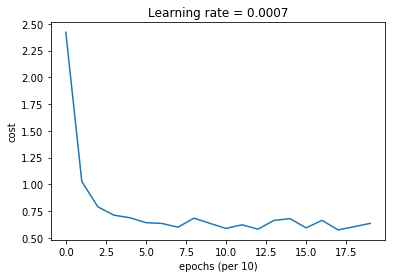

[8.11890149e-06 2.04395458e-11 5.59492536e-02 2.41767325e-04
 8.58194627e-01 2.60504451e-10 8.55667027e-02 9.05800807e-15
 2.34856353e-05 1.60447171e-05]
[0 0 0 0 1 0 0 0 0 0]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Accuracy: 0.87382
[1.78917905e-01 2.49699878e-06 8.45168644e-02 1.04614545e-02
 3.13648224e-02 1.13438275e-04 6.91454100e-01 6.29667433e-08
 3.08286651e-03 8.59890222e-05]
[0 0 0 0 0 0 1 0 0 0]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy: 0.8573
0.7
0.5
Cost after epoch 0: 2.420871
Cost after epoch 10: 1.022264
Cost after epoch 20: 0.786566
Cost after epoch 30: 0.716415
Cost after epoch 40: 0.688794
Cost after epoch 50: 0.640790
Cost after epoch 60: 0.646085
Cost after epoch 70: 0.610462
Cost after epoch 80: 0.692058
Cost after epoch 90: 0.648991
Cost after epoch 100: 0.595121
Cost after epoch 110: 0.636408
Cost after epoch 120: 0.598831
Cost after epoch 130: 0.675152
Cost after epoch 140: 0.689834
Cost after epoch 150: 0.609482
Cost after epoch 160: 0.673916
Cost after epoch 170: 0.5

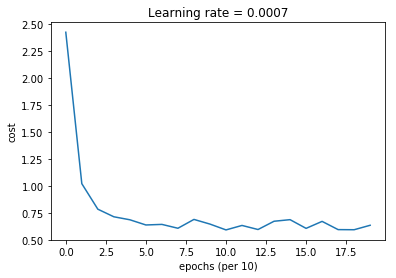

[1.94536472e-05 5.14004053e-09 6.71036308e-02 4.29967497e-04
 8.32366508e-01 2.60705231e-07 9.97513339e-02 1.51118710e-10
 6.84034296e-06 3.21999825e-04]
[0 0 0 0 1 0 0 0 0 0]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Accuracy: 0.87226
[1.75089327e-01 4.84587312e-05 7.00019433e-02 1.78404164e-02
 2.80249201e-02 1.96828574e-03 7.02668614e-01 3.87133286e-06
 4.27300868e-03 8.11546073e-05]
[0 0 0 0 0 0 1 0 0 0]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy: 0.8585
0.7
0.7
Cost after epoch 0: 2.420343
Cost after epoch 10: 1.019243
Cost after epoch 20: 0.784029
Cost after epoch 30: 0.718770
Cost after epoch 40: 0.694921
Cost after epoch 50: 0.645367
Cost after epoch 60: 0.657944
Cost after epoch 70: 0.617512
Cost after epoch 80: 0.702638
Cost after epoch 90: 0.653445
Cost after epoch 100: 0.606484
Cost after epoch 110: 0.646341
Cost after epoch 120: 0.618045
Cost after epoch 130: 0.676422
Cost after epoch 140: 0.705346
Cost after epoch 150: 0.618242
Cost after epoch 160: 0.690434
Cost after epoch 170: 0.6

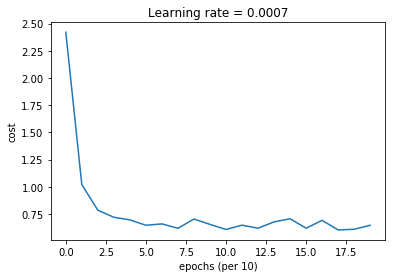

[2.71288782e-05 2.80566835e-08 8.42180218e-02 3.88586890e-04
 8.19492054e-01 1.71269479e-06 9.50767743e-02 2.40208897e-09
 8.70939409e-06 7.86981627e-04]
[0 0 0 0 1 0 0 0 0 0]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Accuracy: 0.87046
[1.91102083e-01 7.68801720e-05 5.07789956e-02 2.20399124e-02
 2.27978135e-02 3.20582025e-03 7.05651055e-01 8.22934973e-06
 4.16781646e-03 1.71394530e-04]
[0 0 0 0 0 0 1 0 0 0]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy: 0.8562
0.7
1
Cost after epoch 0: 2.419782
Cost after epoch 10: 1.014857
Cost after epoch 20: 0.782799
Cost after epoch 30: 0.723263
Cost after epoch 40: 0.703019
Cost after epoch 50: 0.652717
Cost after epoch 60: 0.679495
Cost after epoch 70: 0.621715
Cost after epoch 80: 0.699340
Cost after epoch 90: 0.675988
Cost after epoch 100: 0.601634
Cost after epoch 110: 0.647772
Cost after epoch 120: 0.622316
Cost after epoch 130: 0.680383
Cost after epoch 140: 0.710756
Cost after epoch 150: 0.622450
Cost after epoch 160: 0.708079
Cost after epoch 170: 0.612

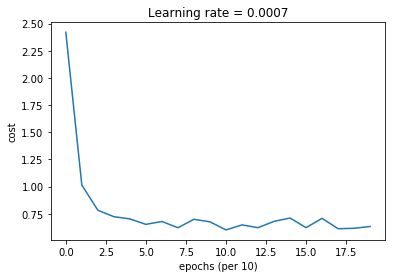

[3.26401608e-05 6.85239292e-08 1.10941656e-01 4.76611536e-04
 7.92525250e-01 6.00943510e-07 9.51126922e-02 2.58998442e-09
 3.53435999e-06 9.06944176e-04]
[0 0 0 0 1 0 0 0 0 0]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Accuracy: 0.87124
[1.72746071e-01 9.82533254e-04 7.73118133e-02 3.69371194e-02
 2.99391469e-02 1.37212040e-02 6.62866180e-01 3.77002834e-05
 5.17960983e-03 2.78622419e-04]
[0 0 0 0 0 0 1 0 0 0]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy: 0.8557
1
0.3
Cost after epoch 0: 2.116724
Cost after epoch 10: 0.427193
Cost after epoch 20: 0.399303
Cost after epoch 30: 0.311287
Cost after epoch 40: 0.311578
Cost after epoch 50: 0.291161
Cost after epoch 60: 0.299542
Cost after epoch 70: 0.276750
Cost after epoch 80: 0.306038
Cost after epoch 90: 0.243109
Cost after epoch 100: 0.277348
Cost after epoch 110: 0.308386
Cost after epoch 120: 0.298915
Cost after epoch 130: 0.302152
Cost after epoch 140: 0.310524
Cost after epoch 150: 0.255066
Cost after epoch 160: 0.282532
Cost after epoch 170: 0.273

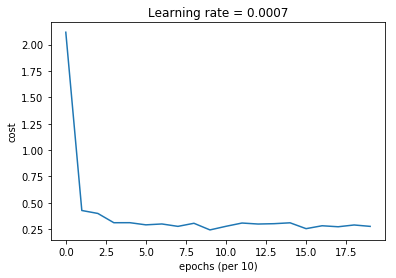

[1.48982130e-04 2.36086122e-06 1.72203860e-01 1.62389707e-05
 8.05496924e-01 9.40601863e-07 2.20957019e-02 1.33748096e-08
 3.45278142e-05 4.50065523e-07]
[0 0 0 0 1 0 0 0 0 0]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Accuracy: 0.9099
[2.39780293e-02 3.59618445e-06 5.22077865e-01 8.01038827e-02
 2.74832845e-02 1.05520076e-07 3.46346222e-01 1.15534312e-11
 1.90386093e-06 5.11032419e-06]
[0 0 1 0 0 0 0 0 0 0]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy: 0.8722
1
0.5
Cost after epoch 0: 2.116470
Cost after epoch 10: 0.427623
Cost after epoch 20: 0.397591
Cost after epoch 30: 0.317212
Cost after epoch 40: 0.313772
Cost after epoch 50: 0.294029
Cost after epoch 60: 0.298523
Cost after epoch 70: 0.284308
Cost after epoch 80: 0.310286
Cost after epoch 90: 0.246071
Cost after epoch 100: 0.276500
Cost after epoch 110: 0.315498
Cost after epoch 120: 0.299278
Cost after epoch 130: 0.306911
Cost after epoch 140: 0.318875
Cost after epoch 150: 0.259274
Cost after epoch 160: 0.283654
Cost after epoch 170: 0.2778

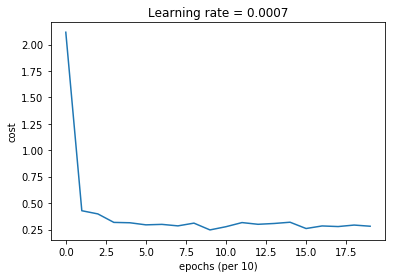

[2.03993995e-04 2.94421475e-05 1.31084553e-01 2.12802740e-05
 8.38508335e-01 9.47263837e-06 3.01140735e-02 5.48636098e-08
 2.66409786e-05 2.15455332e-06]
[0 0 0 0 1 0 0 0 0 0]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Accuracy: 0.9102
[8.74336868e-02 2.73945647e-05 5.92464179e-01 3.99211825e-02
 4.13975626e-02 4.54425530e-06 2.38640536e-01 3.00765849e-10
 6.19544663e-05 4.89595065e-05]
[0 0 1 0 0 0 0 0 0 0]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy: 0.877
1
0.7
Cost after epoch 0: 2.116333
Cost after epoch 10: 0.427742
Cost after epoch 20: 0.397798
Cost after epoch 30: 0.320547
Cost after epoch 40: 0.316014
Cost after epoch 50: 0.297970
Cost after epoch 60: 0.298590
Cost after epoch 70: 0.288288
Cost after epoch 80: 0.308620
Cost after epoch 90: 0.253311
Cost after epoch 100: 0.285047
Cost after epoch 110: 0.321739
Cost after epoch 120: 0.314801
Cost after epoch 130: 0.309020
Cost after epoch 140: 0.319711
Cost after epoch 150: 0.270058
Cost after epoch 160: 0.306253
Cost after epoch 170: 0.28027

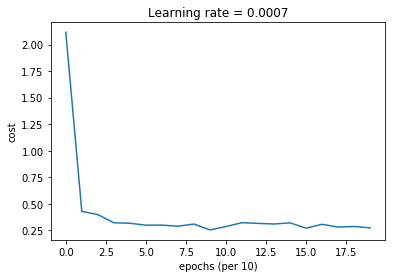

[1.89424576e-04 3.78863053e-05 1.50928457e-01 4.36046004e-05
 8.36089905e-01 4.35265824e-06 1.19702810e-02 2.08860661e-07
 7.32357409e-04 3.52286518e-06]
[0 0 0 0 1 0 0 0 0 0]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Accuracy: 0.90966
[6.76253942e-02 4.23427640e-05 6.51223200e-01 6.38068885e-02
 3.09609829e-02 1.69879833e-05 1.85937008e-01 9.43209706e-09
 1.61868886e-04 2.25317614e-04]
[0 0 1 0 0 0 0 0 0 0]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy: 0.8749
1
1
Cost after epoch 0: 2.116011
Cost after epoch 10: 0.428416
Cost after epoch 20: 0.401989
Cost after epoch 30: 0.321070
Cost after epoch 40: 0.320495
Cost after epoch 50: 0.306958
Cost after epoch 60: 0.307757
Cost after epoch 70: 0.300155
Cost after epoch 80: 0.324887
Cost after epoch 90: 0.266608
Cost after epoch 100: 0.285273
Cost after epoch 110: 0.320959
Cost after epoch 120: 0.310348
Cost after epoch 130: 0.331974
Cost after epoch 140: 0.341415
Cost after epoch 150: 0.277713
Cost after epoch 160: 0.312550
Cost after epoch 170: 0.28793

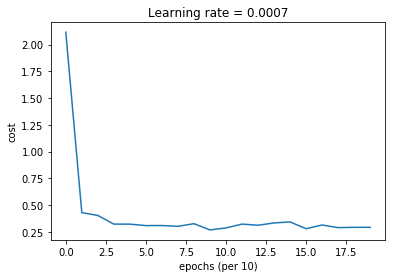

[1.09349983e-04 4.38070601e-05 9.91440792e-02 5.90207877e-05
 8.86422927e-01 1.15224456e-05 1.39670131e-02 2.42119220e-07
 2.40220123e-04 1.81800560e-06]
[0 0 0 0 1 0 0 0 0 0]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Accuracy: 0.9075
[6.21803930e-02 1.78368231e-04 4.56237823e-01 7.47527514e-02
 5.37461631e-02 1.73350503e-04 3.51761600e-01 4.22714264e-07
 5.52676380e-04 4.16452145e-04]
[0 0 1 0 0 0 0 0 0 0]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy: 0.8733


In [118]:
# train 3-layer model - Adam
for i in (0.3, 0.5, 0.7, 1):
    for j in (0.3, 0.5, 0.7, 1):
        print(str(i))
        print(str(j))
        layers_dims = [train_X.shape[0], 25, 12, 10]
        parameters = model(train_X, train_Y, layers_dims, optimizer = "adam",num_epochs = 200,mini_batch_size = 500,regularizer="DropOut_L2",keep_prob=i, lambd=j)

        # Predict
        predict(train_X, train_Y, parameters)
        predict(dev_X, dev_Y, parameters)

Cost after epoch 0: 2.168472
Cost after epoch 10: 0.603711
Cost after epoch 20: 0.529841
Cost after epoch 30: 0.458008
Cost after epoch 40: 0.461499
Cost after epoch 50: 0.440778
Cost after epoch 60: 0.428472
Cost after epoch 70: 0.457020
Cost after epoch 80: 0.431228
Cost after epoch 90: 0.391213
Cost after epoch 100: 0.391579
Cost after epoch 110: 0.437468
Cost after epoch 120: 0.431644
Cost after epoch 130: 0.459896
Cost after epoch 140: 0.475018
Cost after epoch 150: 0.391730
Cost after epoch 160: 0.432670
Cost after epoch 170: 0.409530
Cost after epoch 180: 0.418987
Cost after epoch 190: 0.384007


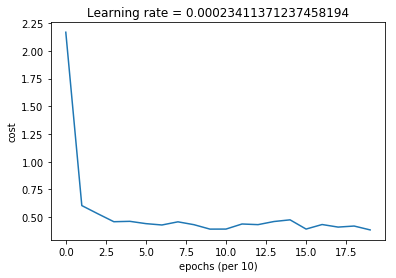

Accuracy: 0.8911272727272728
Accuracy: 0.8728


In [138]:
    layers_dims = [train_X.shape[0], 25, 12, 10]
    parameters = model(train_X, train_Y, layers_dims, optimizer = "adam",num_epochs = 200,mini_batch_size = 500,regularizer="DropOut_L2",keep_prob=0.9, lambd=0.7)

    # Predict
    predict(train_X, train_Y, parameters)
    predict(dev_X, dev_Y, parameters)

Cost after epoch 0: 2.420343
Cost after epoch 10: 1.037564
Cost after epoch 20: 0.801640
Cost after epoch 30: 0.724240
Cost after epoch 40: 0.701449
Cost after epoch 50: 0.657222
Cost after epoch 60: 0.660748
Cost after epoch 70: 0.627238
Cost after epoch 80: 0.697139
Cost after epoch 90: 0.666649
Cost after epoch 100: 0.613812
Cost after epoch 110: 0.644416
Cost after epoch 120: 0.630746
Cost after epoch 130: 0.683712
Cost after epoch 140: 0.699986
Cost after epoch 150: 0.620905
Cost after epoch 160: 0.688686
Cost after epoch 170: 0.611154
Cost after epoch 180: 0.628291
Cost after epoch 190: 0.645841


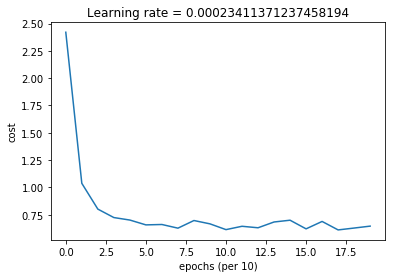

ValueError: too many values to unpack (expected 2)

In [141]:
# train 3-layer model - Adam + Dropout_L2
layers_dims = [train_X.shape[0], 25, 12, 10]
parameters, bn_params = model(train_X, train_Y, layers_dims, optimizer = "adam",num_epochs = 200,mini_batch_size = 500,learning_rate_init = 0.0007,regularizer = "DropOut_L2",keep_prob=0.7, lambd=0.7)

# Predict
print("Adam + Dropout with Weight Decay")
print("Training Accuarcy: ")
predict(train_X, train_Y, parameters, bn_params)
print("Test Accuarcy: ")
predict(dev_X, dev_Y, parameters, bn_params)
print()
      
# train 3-layer model - Minibatch SGD with Momentum + Dropout_L2
layers_dims = [train_X.shape[0], 25, 12, 10]
parameters, bn_params = model(train_X, train_Y, layers_dims, optimizer = "momentum",num_epochs = 200,mini_batch_size = 1,learning_rate_init = 0.00225,regularizer = "DropOut_L2",keep_prob=0.7, lambd=0.7)

# Predict
print("Minibatch GD with Momentum + Dropout with Weight Decay")
print("Training Accuarcy: ")
predict(train_X, train_Y, parameters, bn_params)
print("Test Accuarcy: ")
predict(dev_X, dev_Y, parameters, bn_params)
print()
      
# train 3-layer model - GD + Dropout_L2
layers_dims = [train_X.shape[0], 25, 12, 10]
parameters, bn_params = model(train_X, train_Y, layers_dims, optimizer = "gd",num_epochs = 200,mini_batch_size = 50000,learning_rate_init = 0.005,regularizer = "DropOut_L2",keep_prob=0.7, lambd=0.7)

# Predict
print("GD + Dropout with Weight Decay")
print("Training Accuarcy: ")
predict(train_X, train_Y, parameters, bn_params)
print("Test Accuarcy: ")
predict(dev_X, dev_Y, parameters, bn_params)
print()